# Imports

In [37]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Functions 

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [3]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img):
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [4]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
        #print("Gender: ",dataset.loc[int(img_name.split('/')[-1].split('.')[0])]['gender'])

    #convert Series of numpy arrays to 2D np
    #images_np=np.array(images.values.tolist())
    print("Dataset type before augmentation:",type(dataset_copy), "with sahpe:",dataset_copy.shape)
    dataset_np=np.stack(dataset_copy)
    print("Dataset type after augmentation:",type(dataset_np), "with sahpe:",dataset_np.shape)
 
    #convert 2D np to pd
    dataset_pd = pd.DataFrame(dataset_np)
    print("Convert 2D np array to pd again...")
    #print(dataset_pd.head())
    return(dataset_pd)

In [5]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,labels):
    labels=np.array(labels)
    NaNvaluesData=np.isnan(labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")


    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")
        
    return

# Read Data

In [6]:
dataset = pd.read_csv('../Datasets/celeba/labels.csv', sep = '\t', usecols = [1,2])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (5000, 2)


,img_name,gender
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,1
3,3.jpg,-1
4,4.jpg,-1


In [7]:
images = dataset.iloc[:,0]
labels = dataset.iloc[:,1]

**Example of a picture in CelebA dataset:**

Gender:  -1
65025


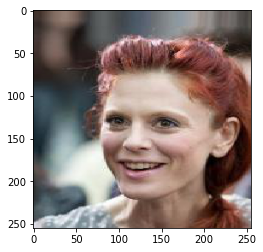

In [8]:
# set variables 
images_folder = '../Datasets/celeba/img/'
EXAMPLE_PIC = images_folder + '1.jpg'

# plot picture and attributes
#img = load_img(EXAMPLE_PIC)
#reduce the dimensions for simplicity
img = load_img(EXAMPLE_PIC,target_size=(255,255))
plt.imshow(img)
print("Gender: ",dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['gender'])

pix_val = list(img.getdata())
print(len(pix_val))

In [9]:
x = img_to_array(img)/255.
x = x.reshape((1,)+x.shape)
x=x.flatten()
x=x.reshape(255,255,3)
print(x.shape)

(255, 255, 3)


In [10]:
females = dataset[dataset['gender']==-1].count()[0]
males = dataset[dataset['gender']==1].count()[0]
print('Females: {}  | Males: {}'.format(females,males))
print("Balanced Dataset!!")

Females: 2500  | Males: 2500
Balanced Dataset!!


## Convert images dataframe to pixel reshaped images dataframe

In [11]:
size=(255,255)
reshaped_images=create_flattened_dataset(images,size)

Dataset type before augmentation: <class 'pandas.core.series.Series'>
Dataset type after augmentation: <class 'numpy.ndarray'> with sahpe: (5000, 195075)
Convert 2D np array to pd again...


**Check for NaN values** (make it function)

In [12]:
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


**Train, Dev, Test split** 

In [13]:
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images, labels)

Train Set: (3500, 195075) | Dev Set: (750, 195075) | Test Set: (750, 195075)


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


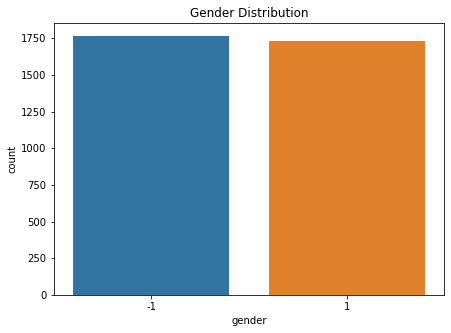

In [14]:
plt.figure(figsize=(7,5))
plt.xlabel('Gender')
plt.title('Gender Distribution')
sns.countplot(y_train);

**Balanced Train Samples**

# Baseline Classification Estimator

In [19]:
#default neighbors=5
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train,y_train)
preds = clf.predict(X_dev)
print(classification_report(y_dev, preds))
print("\nAccuracy Score: ","{:.0%}".format(accuracy_score(y_dev, preds)))

              precision    recall  f1-score   support

          -1       0.65      0.76      0.70       351
           1       0.75      0.65      0.70       399

    accuracy                           0.70       750
   macro avg       0.70      0.70      0.70       750
weighted avg       0.71      0.70      0.70       750


Accuracy Score:  70%


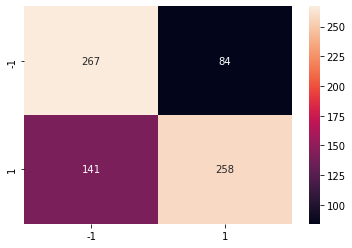

In [58]:
conf_matrix = confusion_matrix(y_dev, preds)
labels=['-1','1']
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.show()

# Preproccessing Data